In [2]:
#pip install PyCustomFocus

In [27]:
#pip install s2ism

In [2]:
#pip install opencv-python

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile
from PIL import Image
import h5py
import brighteyes_ism.analysis.Graph_lib as gra                    #library dedicated to data plots
from brighteyes_ism.analysis import APR_lib as apr                 #import library to perform shift-vector analysis
from brighteyes_ism.analysis import Tools_lib as tool
import brighteyes_ism.simulation.PSF_sim as sim                    #library for PSFs simulation
import brighteyes_ism.dataio.mcs as mcs                            #library for reading experimental data
import brighteyes_ism.analysis.Deconv_lib as dec

from s2ism import mag_finder as mag                                 # library needed to perform magnification retrieval on the raw ISM data
from s2ism import shift_vectors_minimizer as svm                   #import library to perform shift-vectors estimation
from s2ism import psf_estimator as est                             # import library to simulate proper PSFs
from s2ism import s2ism as s2  
import cv2 as cv

# Load data

In [6]:
filename = "C:/Users/prism/Documents/carmaX/measurements/200nm lente 10cm"
savename = "C:/Users/prism/Documents/carmaX/measurements/200nm lente 10cm"

#filename = "C:/Users/prism/Documents/carmaX/measurements/2024 07 22 prove obiettivi/sfere 200nm lente10a11 30giusta 20um"
#savename = "C:/Users/prism/Documents/carmaX/measurements/2024 07 22 prove obiettivi/sfere 200nm lente10a11 30giusta 20um"

## Load Brighteyes dataset

In [152]:
data, meta = mcs.load(filename + '.h5')
pxsizex = meta.dx
print('Original data shape: ' + str(data.shape) +'\n')
data=data.sum(axis=(0,1,4))
print('ISM dataset shape: ' + str(data.shape)+'\n')
#meta.Print()
print('Pixelsize [um]: '+ str(pxsizex))

Original data shape: (1, 1, 1250, 1250, 81, 25)

ISM dataset shape: (1250, 1250, 25)

Pixelsize [um]: 0.04


## Load Carma dataset

In [7]:
f = h5py.File(filename + '.h5', 'r')
group = f['Image']
imgFormat=group.attrs['I_Height'][0]       #pixels
Depth=group.attrs['I_Depth'][0]            #repetitions/z
ImgFoV=group.attrs['I_XSpan[um]'][0]       #micron
pxsizex=group.attrs['I_XPixelSize[nm]'][0]/1000 #micron
ZSpan=group.attrs['I_ZSpan[um]'][0]        #micron
pxsizez=group.attrs['I_ZPixelSize[nm]'][0]/1000 #micron
Duration=group.attrs['M_Duration[ms]'][0]  #ms
DwellTime=Duration/(Depth*imgFormat**2)    #ms
Fingerprint_h5 = group['Fingerprint'][()]
Data_h5= group['SPAD'][()]
f.close()

In [10]:
spadFormat=7
Fingerprint_meta = np.reshape(Fingerprint_h5, (spadFormat,spadFormat))
Data_h5=np.reshape(Data_h5,(Depth,imgFormat,imgFormat,spadFormat**2)) 
print(Data_h5.shape)
data=Data_h5.sum(axis=(0))
print(data.shape)
print('\nDwell time: ' + str(DwellTime))
print('FoV [um]: ' + str(ImgFoV))
print('Pixel size [um]: ' +str(pxsizex))

(1, 512, 512, 49)
(512, 512, 49)

Dwell time: 0.36621374895095826
FoV [um]: 20.0
Pixel size [um]: 0.0390625


In [11]:
#data=Data_h5[:,:,:,:].sum(axis=(0))
#print(data.shape)

#index5=[8,9,10,11,12,15,16,17,18,19,22,23,24,25,26,29,30,31,32,33,36,37,38,39,40]
#index3=[16,17,18,23,24,25,30,31,32]
#index1=[17,23,24,25,31]
#d5 =[data[:,:,i] for i in index5]
#d5=np.transpose(np.asarray(d5),(1,2,0))
#print(d5.shape)

index3=[6,7,8,11,12,13,16,17,18]
d3 =[data[:,:,i] for i in index3]
d3=np.transpose(np.asarray(d3),(1,2,0))
print(d3.shape)
index1=[7,11,12,13,17]
d1 =[data[:,:,i] for i in index1]
d1=np.transpose(np.asarray(d1),(1,2,0))
print(d1.shape)

(512, 512, 9)
(512, 512, 5)


# Check Dataset

### Check fingerprint

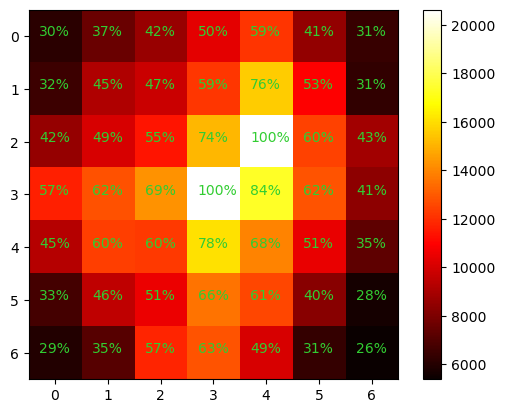

In [34]:
fingerprint = tool.fingerprint(data[:,:,:])
fingerprint[1,5]=(fingerprint[1,4]+fingerprint[1,6])/2 #smooth spad 12
c= int((spadFormat-1)/2)  #change if the maximum is not at the center

fig= plt.figure()
plt.imshow(fingerprint, cmap='hot')
plt.colorbar()
for i in range(7):
    for j in range(7):
        plt.text(j-0.3,i, str(round(fingerprint[i,j]*100/fingerprint[c,c])) + '%', color='limegreen') 
        
fig.savefig(savename + ' fingeprint.png')

In [52]:
print(fingerprint)
np.savetxt(savename + ' fingerprint.txt', fingerprint, delimiter=' ')

[[ 58081  73941  95219 100971  91303  70870  54993]
 [ 71381  89403 124126 148694 139688 313450  70214]
 [ 81863 115112 179760 237727 221361 141576  88710]
 [ 91336 135659 215400 293435 262987 156883  96631]
 [ 91788 133013 189433 236007 209222 139788  93638]
 [ 76121 103385 130355 148350 135876 105092  77358]
 [ 51938  66516  80301  94170  92004  75137  61923]]


### Check Images stack

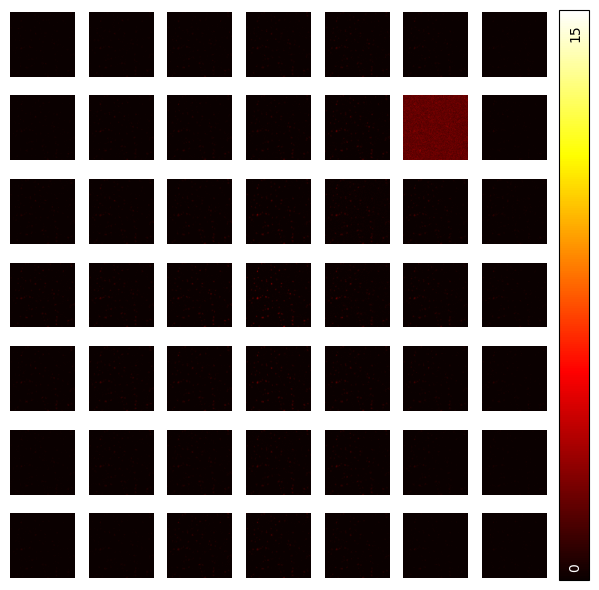

In [14]:
fig_1 = gra.ShowDataset(data,normalize = True, colorbar=True)

In [15]:
#Save all single images as a stack
tifffile.imwrite(savename + ' stack.tiff', np.transpose(data[:,:,:], (2,0,1)))

(<Figure size 640x480 with 2 Axes>, <Axes: >)

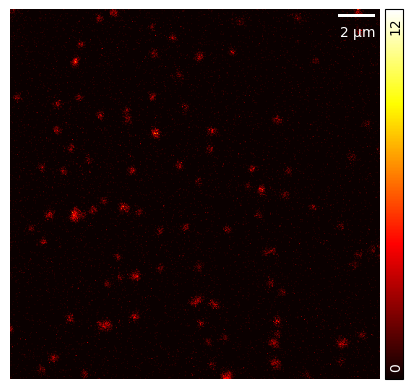

In [35]:
gra.ShowImg(data[:,:,24], pxsize_x = pxsizex)

# Image reconstruction

## Confocal

(<Figure size 640x480 with 2 Axes>, <Axes: >)

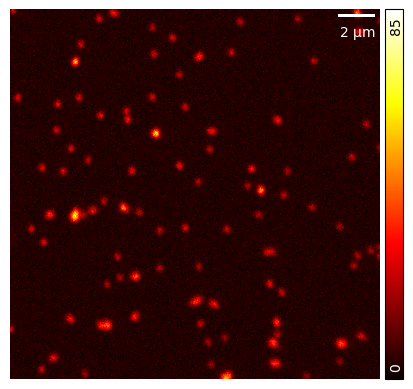

In [17]:
img_sum = data.sum(axis=-1)
gra.ShowImg(img_sum, pxsize_x = pxsizex)

In [18]:
im = Image.fromarray(img_sum)
im.save(savename + ' confocal.tiff')

## APR

In [19]:
#ISM image
usf = 10  #upsampling factor = subpixel precision
ref = 24 #reference image to compute the shift vectors

shift, img_ism = apr.APR(data, usf, ref, filter_sigma=1, pxsize = pxsizex*1000) #pxsize in nm
img_ism_sum = img_ism.sum(axis=-1) 

C:\Users\prism\anaconda3\Lib\brighteyes_ism\analysis\Graph_lib.py:544: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(shift[:, 0], shift[:, 1], s=80, c=color, edgecolors='black', cmap=cmap)


Text(0.5, 1.0, 'Shift Vectors')

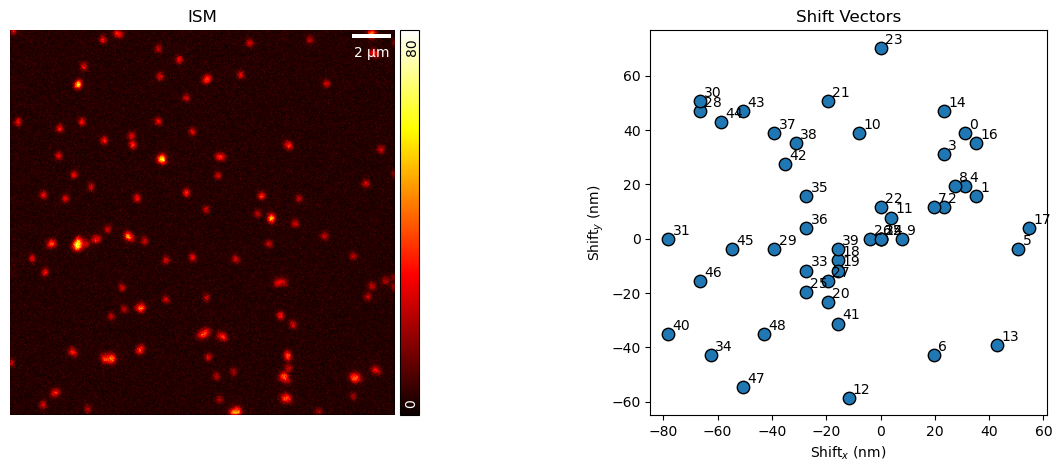

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

gra.ShowImg(img_ism_sum, pxsize_x = pxsizex, fig = fig, ax = ax[0])
ax[0].set_title('ISM')

gra.PlotShiftVectors(shift, fig = fig, ax = ax[1])
ax[1].set_title('Shift Vectors')
#ax[1].set_xlim(-400,500)
#ax[1].set_ylim(-300,400)

In [21]:
im = Image.fromarray(img_ism_sum)
im.save(savename + ' ISM.tiff')

extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(savename + ' shift vectors.png', bbox_inches=extent.expanded(1.2, 1.2))

#np.savetxt(savename + ' shift vectors.txt', shift, delimiter=' ')

Text(0.5, 1.0, 'ISM')

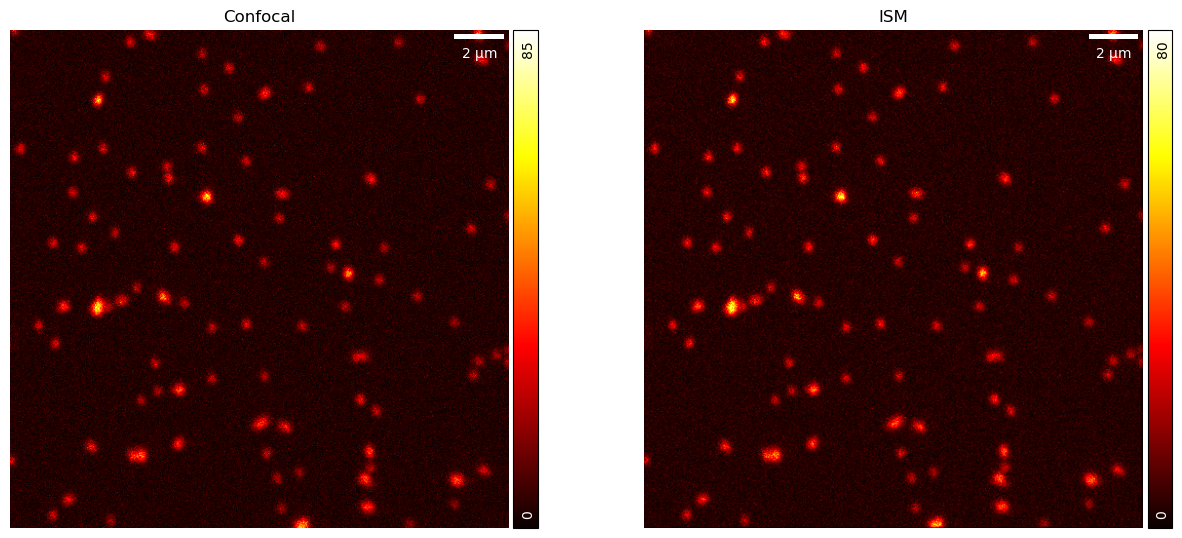

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

gra.ShowImg(img_sum, pxsize_x = pxsizex, fig = fig, ax = ax[0])
ax[0].set_title('Confocal')

gra.ShowImg(img_ism_sum, pxsize_x = pxsizex, fig = fig, ax = ax[1])
ax[1].set_title('ISM')

# Deconvolution

### PSF extraction

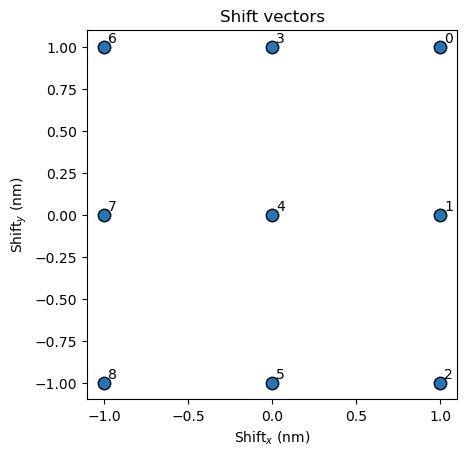

In [23]:
#creation of the phantom grid 
shift_sim = svm.shift_matrix()

fig_4 = gra.PlotShiftVectors(shift_sim)

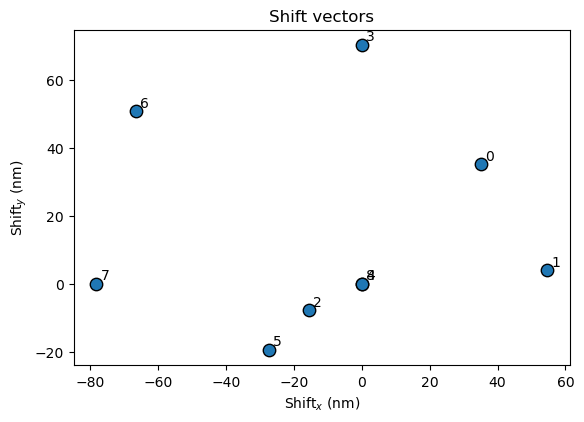

In [24]:
#shift-vectors crop 
shift_vectors_crop = svm.crop_shift(shift)

fig_5 = gra.PlotShiftVectors(shift_vectors_crop)

In [38]:
parameters = svm.find_parameters(shift)
print(f'Dilation = {parameters[0]:.2f} nm')
print(f'Rotation = {parameters[1]:.2f} rad')
print(f'Mirroring = {parameters[2]:.2f}')

Dilation = 33.63 nm
Rotation = -0.08 rad
Mirroring = 1.00


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Shift vectors'}, xlabel='Shift$_x$ (nm)', ylabel='Shift$_y$ (nm)'>)

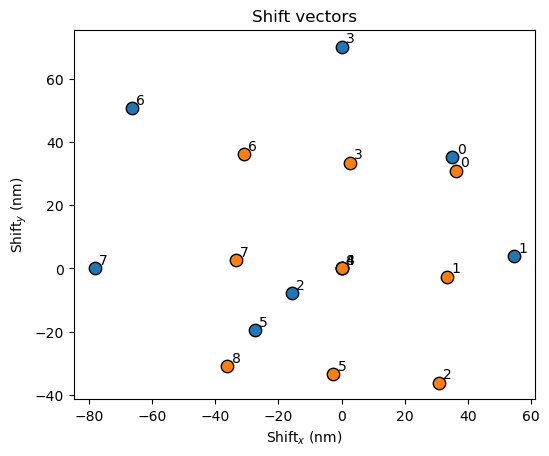

In [39]:
shift_sim_rot = svm.transform_shift_vectors(parameters, shift_sim)

fig_6, ax = gra.PlotShiftVectors(shift_vectors_crop)
gra.PlotShiftVectors(shift_sim_rot, fig = fig_6, ax = ax)

### Magnification

In [40]:
na = 1.1  # numerical aperture
ex_wl = 750   # excitation wavelength [nm]
em_wl = 550  # emission wavelength [nm]
pxpitch = 75e3  # detector pixel pitch [nm]
pxdim = 30e3  # detector pixel size [nm]

In [41]:
magn = mag.find_mag(parameters[0], ex_wl, em_wl, pxpitch, pxdim, na, nph=2) #nph is either 2-photon or 1-photon

print(f'Magnification value retrieved = {magn:.2f}')

Magnification value retrieved = 1075.00


## PSF simulation

In [42]:
exPar = sim.simSettings()
exPar.na = 1.1  # numerical aperture
exPar.wl = 750  # wavelength [nm]
exPar.gamma = 45 # parameter describing the light polarization
exPar.beta = 90  # parameter describing the light polarization
exPar.n = 1.3    # refractive index of immersion medium
exPar.mask_sampl = 60       #sampling points of the phase mask in simulation

emPar = exPar.copy()
emPar.wl = 550   # wavelength [nm]
emPar.na = 1.1
emPar.n = 1.3

grid = sim.GridParameters()
grid.N = 7 # number of elements for each axis of the detector array, assumed squared
grid.pxpitch = 75e3  # detector pixel pitch [nm]
grid.pxdim = 30e3  # detector pixel size [nm]
grid.pxsizex = pxsizex*1e3 # pixel size of acquisition [nm]
grid.M = magn

In [43]:
#optimal_bkg_plane, psf_stack = est.find_out_of_focus_from_param(grid.pxsizex, exPar, emPar, mode ='Pearson', stack='positive', graph = True)
#print(f'Optimal out-of-focus position = {optimal_bkg_plane} nm')

In [44]:
grid_simul = est.GridFinder(grid)
grid_simul.estimate(data, exPar.wl, emPar.wl, emPar.na, nph=2)
print(grid_simul.shift)
print(grid_simul.M) #check a similar magnification to the one found before

33.00787745094403
1094.0


In [175]:
#ups = 1

#grid_simul.Nz=1
#grid_simul.pxsizex=pxsizex*1e3/ups
#grid_simul.pxsizez=optimal_bkg_plane
#grid_simul.Nx = 40*ups

#psf, det_psf, ex_psf = sim.SPAD_PSF_3D(grid_simul, exPar, emPar,n_photon_excitation = 1)

Calculating the PSFs stack from z = 0 nm to z = 0 nm:


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


In [45]:
ups = 1

grid.Nz=1
grid.pxsizex=pxsizex*1e3/ups
#grid.pxsizez=optimal_bkg_plane
grid.Nx = 30*ups

psf, det_psf, ex_psf = sim.SPAD_PSF_3D(grid, exPar, emPar,n_photon_excitation = 1)

Calculating the PSFs stack from z = 0 nm to z = 0 nm:


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


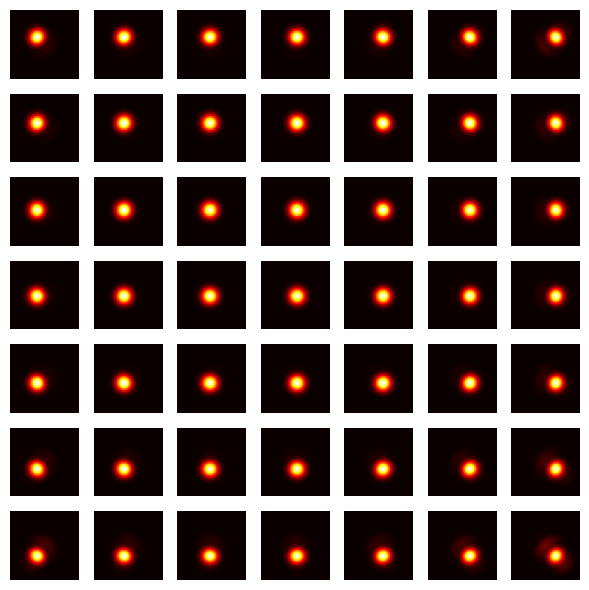

In [46]:
fig1 = gra.ShowDataset(psf[0])
#fig2 = gra.ShowDataset(psf[1])

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Shift vectors'}, xlabel='Shift$_x$ (nm)', ylabel='Shift$_y$ (nm)'>)

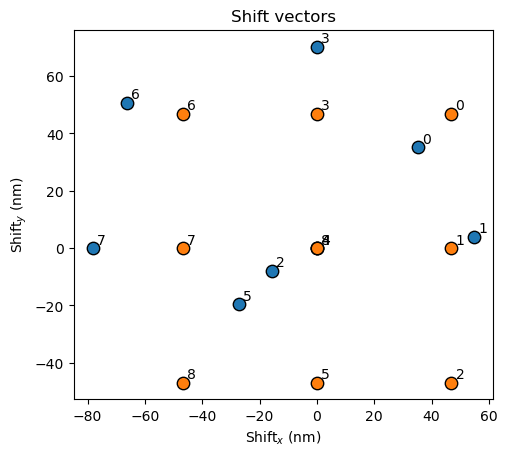

In [47]:
ref = 24        # we define the SPAD channel chosen as reference to perform the cross correlation for the shift vector extraction
shift_PSF = apr.APR(psf[0] , 10 , ref)[0]*grid_simul.pxsizex

fig, ax = gra.PlotShiftVectors(svm.crop_shift(shift))
gra.PlotShiftVectors(svm.crop_shift(shift_PSF), fig = fig, ax = ax)

## Multi-image Deconvolution

In [48]:
img_deconv = dec.MultiImg_RL_FFT(psf.sum(axis=(0)), data, max_iter = 5)
#print(data.shape)
#print(psf.sum(axis=(0)).shape)

Multi-image deconvolution:


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


(<Figure size 640x480 with 2 Axes>, <Axes: >)

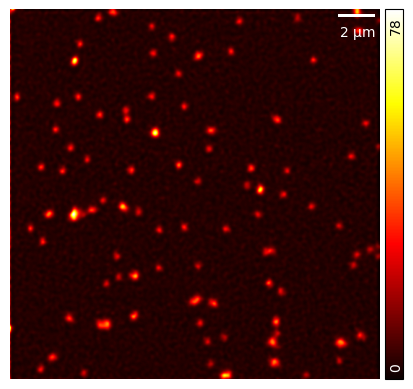

In [49]:
gra.ShowImg(img_deconv, pxsize_x = pxsizex)

Text(0.5, 1.0, 'Deconvolution')

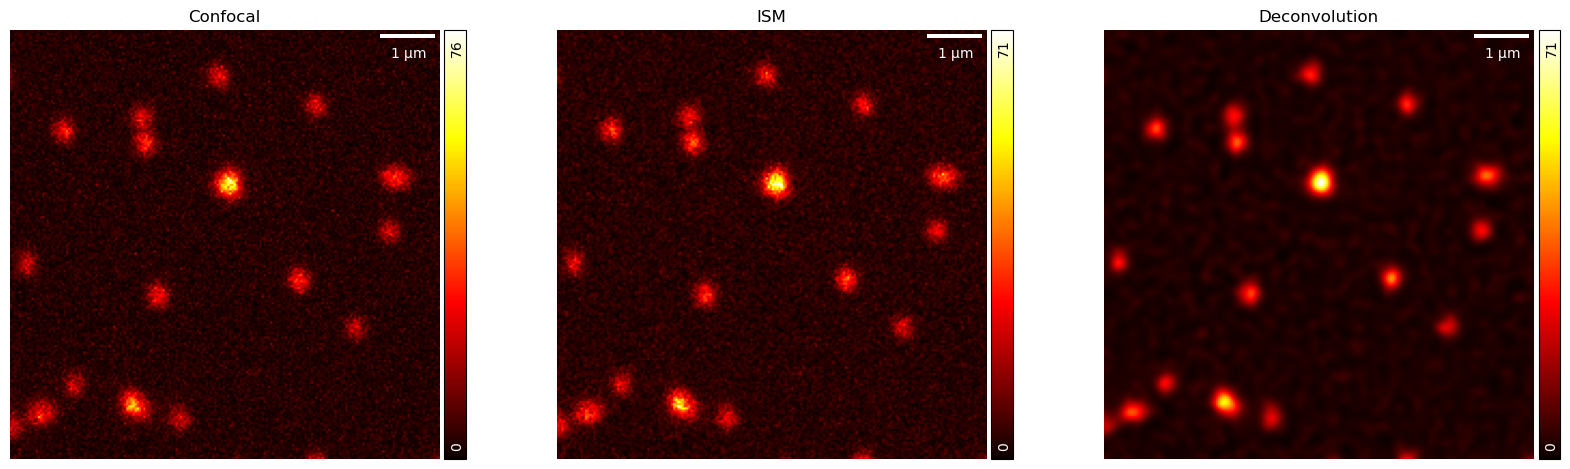

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(20,8))

gra.ShowImg(img_sum[100:300,100:300], pxsize_x = pxsizex, fig = fig, ax = ax[0])
ax[0].set_title('Confocal')

gra.ShowImg(img_ism_sum[100:300,100:300], pxsize_x = pxsizex, fig = fig, ax = ax[1])
ax[1].set_title('ISM')

gra.ShowImg(img_deconv[100:300,100:300], pxsize_x = pxsizex, fig = fig, ax = ax[2])
ax[2].set_title('Deconvolution')

In [83]:
im = Image.fromarray(img_deconv)
im.save(savename + ' deconv.tiff')